# Quick Setup - Run All Imports and Configurations
This cell will re-initialize everything after kernel restart

Paper link : https://arxiv.org/abs/1706.03762  <br>


<h1> Translating hindi to english </h1>

In [1]:
#to define the models
import torch
import torch.nn as nn
import torch.optim as optim

#to load,iterate and process the dataset
import torchtext
from torchtext.datasets import Multi30k
from torchtext.data.metrics import bleu_score
from torchtext.data import Field,BucketIterator

#to visualize loss plots on localhost while training
# See https://pytorch.org/docs/stable/tensorboard.html for more details
from torch.utils.tensorboard import SummaryWriter

In [2]:
#miscallaneous imports

import math
import spacy
import random
import numpy as np
from time import time


from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set()

In [3]:
# get GPU details if available

def get_gpu_details():
    t = torch.cuda.get_device_properties(0).total_memory
    c = torch.cuda.memory_cached(0)
    a = torch.cuda.memory_allocated(0)
    print(torch.cuda.get_device_name())
    print(f'Total GPU Memory {t} B , Cached GPU Memory {c} B, Allocated GPU Memory {a} B')
    
    
    
if torch.cuda.is_available():
    device='cuda:0'
else:
    device='cpu'
print(f'Current Device: {device}')
if device=='cuda:0':
    torch.cuda.empty_cache()
    get_gpu_details()

Current Device: cuda:0
NVIDIA GeForce GTX 1650
Total GPU Memory 3897229312 B , Cached GPU Memory 0 B, Allocated GPU Memory 0 B


/tmp/ipykernel_127504/2747321639.py:5: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  c = torch.cuda.memory_cached(0)


In [4]:
batch_size = 128


SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
spacy_english = spacy.load('en_core_web_sm')

# Create a simple Hindi tokenizer class that mimics spacy's interface
class SimpleToken:
    def __init__(self, text):
        self.text = text

class SimpleHindiTokenizer:
    def tokenize(self, text):
        # Simple tokenizer for Hindi - splits on whitespace
        # Keep punctuation separate
        import re
        # First split by whitespace, then separate trailing punctuation
        tokens = []
        for word in text.split():
            # Match word characters (including Hindi) and punctuation separately
            parts = re.findall(r'[\u0900-\u097F\w]+|[^\u0900-\u097F\w\s]', word, re.UNICODE)
            tokens.extend(parts)
        return tokens
    
    def __call__(self, text):
        # Make it callable like spacy tokenizer, return token objects
        tokens = self.tokenize(text)
        return [SimpleToken(token) for token in tokens]

spacy_hindi = SimpleHindiTokenizer()

In [6]:
def tokenize_english(eng_text):
    return [token.text for token in spacy_english.tokenizer(eng_text)]

def tokenize_hindi(hindi_text):
    # Use the simple Hindi tokenizer
    return spacy_hindi.tokenize(hindi_text)

In [7]:
tokenize_english('Lets play a game!!')

['Lets', 'play', 'a', 'game', '!', '!']

In [8]:
tokenize_hindi('बच्चे पार्क में खेल रहे हैं')

['बच्चे', 'पार्क', 'में', 'खेल', 'रहे', 'हैं']

Create text processing pipelines, first channel of the input to the model will be batch, so set batch_first = True

In [9]:
source_process_pipeline = Field(tokenize = tokenize_hindi,
                       init_token = '<sos>',
                       eos_token = '<eos>',
                       lower = True,
                       batch_first = True)


target_process_pipeline = Field(tokenize = tokenize_english,
                       init_token = '<sos>',
                       eos_token = '<eos>',
                       lower = True,
                       batch_first = True)

In [10]:
# Workaround for SSL certificate issue when downloading Multi30k dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Load the dataset and split into train,test and validation <br>
Refer the below link for more details <br>
https://torchtext.readthedocs.io/en/latest/datasets.html#multi30k <br>
https://pytorchnlp.readthedocs.io/en/latest/_modules/torchnlp/datasets/multi30k.html 


In [11]:
# Alternative approach: Download Multi30k manually with retry logic
import os
import tarfile
import urllib.request

def download_multi30k():
    data_dir = '.data/multi30k'
    os.makedirs(data_dir, exist_ok=True)
    
    # Note: Multi30k is originally German-English, we're using Hindi-English sample data
    # For actual Hindi-English translation, you would need a proper Hindi-English parallel corpus
    
    # Try using the standard Multi30k loader first, if it fails use alternative
    try:
        # This will fail since Multi30k doesn't have Hindi data
        train_data, validation_data, test_data = Multi30k.splits(
            exts=('.hi', '.en'),
            fields=(source_process_pipeline, target_process_pipeline)
        )
        return train_data, validation_data, test_data
    except Exception as e:
        print(f"Standard download failed: {e}")
        print("Attempting alternative download method...")
        
        # Use torchtext's built-in datasets with alternative approach
        # Create simple train/val/test splits from scratch if download fails
        from torchtext.data import Dataset, Example
        
        # Create minimal sample data for demonstration
        print("Creating sample dataset for demonstration...")
        
        sample_hi = [
            "एक आदमी बेंच पर बैठा है।",
            "एक औरत सड़क पर चल रही है।",
            "बच्चे पार्क में खेल रहे हैं।",
        ] * 100  # Repeat to create larger dataset
        
        sample_en = [
            "A man sits on a bench.",
            "A woman walks down the street.",
            "Children play in the park.",
        ] * 100
        
        # Create examples
        examples = [
            Example.fromlist([hi, en], [('src', source_process_pipeline), ('trg', target_process_pipeline)])
            for hi, en in zip(sample_hi, sample_en)
        ]
        
        # Split into train/val/test
        train_size = int(0.7 * len(examples))
        val_size = int(0.15 * len(examples))
        
        train_examples = examples[:train_size]
        val_examples = examples[train_size:train_size + val_size]
        test_examples = examples[train_size + val_size:]
        
        train_data = Dataset(train_examples, [('src', source_process_pipeline), ('trg', target_process_pipeline)])
        validation_data = Dataset(val_examples, [('src', source_process_pipeline), ('trg', target_process_pipeline)])
        test_data = Dataset(test_examples, [('src', source_process_pipeline), ('trg', target_process_pipeline)])
        
        return train_data, validation_data, test_data

train_data, validation_data, test_data = download_multi30k()
print(f"Train examples: {len(train_data)}")
print(f"Validation examples: {len(validation_data)}")
print(f"Test examples: {len(test_data)}")

Standard download failed: [Errno 2] No such file or directory: '.data/multi30k/train.hi'
Attempting alternative download method...
Creating sample dataset for demonstration...
Train examples: 210
Validation examples: 45
Test examples: 45


In [12]:
train_data.fields

{'src': <torchtext.data.field.Field at 0x771ffce39e20>,
 'trg': <torchtext.data.field.Field at 0x771ffce3a3c0>}

Build the vocabulary

In [13]:
source_process_pipeline.build_vocab(train_data,min_freq=2)
target_process_pipeline.build_vocab(train_data,min_freq=2)

In [14]:
len(source_process_pipeline.vocab)

20

In [15]:
len(target_process_pipeline.vocab)

19

Token indices for both source and target begin from 0 for each token.

In [16]:
list(source_process_pipeline.vocab.stoi.items())[:50]

[('<unk>', 0),
 ('<pad>', 1),
 ('<sos>', 2),
 ('<eos>', 3),
 ('एक', 4),
 ('पर', 5),
 ('है।', 6),
 ('आदमी', 7),
 ('औरत', 8),
 ('खेल', 9),
 ('चल', 10),
 ('पार्क', 11),
 ('बच्चे', 12),
 ('बेंच', 13),
 ('बैठा', 14),
 ('में', 15),
 ('रही', 16),
 ('रहे', 17),
 ('सड़क', 18),
 ('हैं।', 19)]

In [17]:
list(target_process_pipeline.vocab.stoi.items())[:50]

[('<unk>', 0),
 ('<pad>', 1),
 ('<sos>', 2),
 ('<eos>', 3),
 ('.', 4),
 ('a', 5),
 ('the', 6),
 ('bench', 7),
 ('children', 8),
 ('down', 9),
 ('in', 10),
 ('man', 11),
 ('on', 12),
 ('park', 13),
 ('play', 14),
 ('sits', 15),
 ('street', 16),
 ('walks', 17),
 ('woman', 18)]

<h1>Define the iterator</h1>

<b>BucketIterator</b>: <br>
Defines an iterator that batches examples of similar lengths together.

Minimizes amount of padding needed while producing freshly shuffled batches for each new epoch. See pool for the bucketing procedure used.
<br><br>
refer:
https://torchtext.readthedocs.io/en/latest/data.html#bucketiterator

In [18]:
train_iterator, validation_iterator, test_iterator = BucketIterator.splits(
    (train_data, validation_data, test_data), 
     batch_size = batch_size,
     sort=False,  # Disable sorting to avoid comparison issues
     device = device)

In [19]:
print(next(iter(train_iterator)))


[torchtext.data.batch.Batch of size 82]
	[.src]:[torch.cuda.LongTensor of size 82x9 (GPU 0)]
	[.trg]:[torch.cuda.LongTensor of size 82x9 (GPU 0)]


# Build the transformer model

The Transformer's encoder does not attempt to compress the entire source sentence, $X = (x_1, ... ,x_n)$, into a single context vector, $z$. Instead it produces a sequence of context vectors, $Z = (z_1, ... , z_n)$. So, if our input sequence was 5 tokens long we would have $Z = (z_1, z_2, z_3, z_4, z_5)$. Why do we call this a sequence of context vectors and not a sequence of hidden states? A hidden state at time $t$ in an RNN has only seen tokens $x_t$ and all the tokens before it. However, each context vector here has seen all tokens at all positions within the input sequence.

<img src = './images/encoder.png'>

<h2>Dimensional Notations followed </h2>
<h3> =================================================== </h3>
<h3>bsiz = batch_size</h3>
<h3>slen = source_length</h3>
<h3>hdim = hidden_dimension size</h3>
<h3>qlen = query length</h3>
<h3>vlen = value length</h3>
<h3>klen = key length</h3>
<h3>tlen = target length</h3>
<h3>nheads = number of heads in multihead attention</h3>
<h3> =================================================== </h3>

<h2>The Encoder</h2>

<h4> Token Embeddings and Positional Encodings </h4>

Refer : https://jalammar.github.io/illustrated-transformer/

<img src= './images/positional_encoding_vectors.png' width = 500, height = 400>

The input sequence of tokens are passed through an embedding layer, this embeddin layer can be of any type, either use pretrained embeddings(Word2Vec,GLoVE,fasttext) etc. or can be learned on their own.
<br><br>
However since we are not using RNNs, the model has no idea about the positional sequence of input tokens,i.e the model doesn't know which word comes after what word and the relative distances between any pair of words. Hence another embedding is added to the original input embedding, which is called as positional embedding.
<br><br>
The positional encoding has a fixed vocab size 'x' which means the model can accept sequences which are 'x' tokens long.

Next, the token and positional embeddings are elementwise summed together to get a vector which contains information about the token and also its position with in the sequence. However, before they are summed, the token embeddings are multiplied by a scaling factor which is $\sqrt{d_{model}}$, where $d_{model}$ is the hidden dimension size, hid_dim. This supposedly reduces variance in the embeddings and the model is difficult to train reliably without this scaling factor. Dropout is then applied to the combined embeddings.(mentioned in section 3.4 of the <a href = "https://arxiv.org/abs/1706.03762">paper</a>)



The combined embeddings are then passed through $N$ encoder layers to get $Z$, which is then output and can be used by the decoder.

WE'LL BE LEARNING THE POSITONAL ENCODINGS RATHER THAN USING STATIC PE(AS USED IN THE PAPER)

The input sequence is the masked with a source_mask which masks the input sequence wherever there is padding. It marks the token if it is not a pad token as 1 and 0 when it is a pad token.This makes sense because the pad tokens do not serve any useful purpose apart from making the lengths similar.So the model should not apply attention over these pad tokens and hence they are masked with 0.

In [20]:
class Encoder(nn.Module):
    def __init__(self,input_dimension,hidden_dimension,
                 number_encoder_layers,num_attention_heads,pointwise_ff_dim,
                 dropout,device,max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.token_embeddings = nn.Embedding(input_dimension,hidden_dimension)
        self.positional_embeddings = nn.Embedding(max_length,hidden_dimension)
        
        
        self.encoder_blocks = nn.ModuleList([EncoderBlock(hidden_dimension,num_attention_heads,
                                                  pointwise_ff_dim,dropout,device)
                                     for _ in range(number_encoder_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        # sqrt(d_model)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dimension])).to(device)
        
        
    def forward(self,source,source_mask):
        
        #src = (bsiz,slen)
        #src_mask = (bsiz,1,1,slen)
        
        batch_size = source.shape[0]
        source_length = source.shape[1]
        
        
        positions = torch.arange(0,source_length).unsqueeze(0)
        #positions = (source_length,1)
        
        positions = positions.repeat(batch_size,1).to(self.device)
        #positions = (batch_size,source_length)
        #see posmask_example1 below after this cell for clarification
        
        #add the token_embeddings to positional_encodings for letting 
        #the model know about the sequence of occurance of tokens
        
        #get the embeddings for the token and multiply with sqrt(d_model) scale
        source = self.token_embeddings(source)*self.scale
        
        #add the positional embeddings to the source
        source = source + self.positional_embeddings(positions)
        
        #apply dropout
        source = self.dropout(source)
        #source = (bsiz,slen,hdim) see the image below for tensor shape clarification
        
        for encoder_block in self.encoder_blocks:
            source = encoder_block(source,source_mask)
        
        return source

<h3> Few visualizations to clarify the above shapes and tensors</h3>

<b> Below image shows the shape of a tensor after passing through the token and positional embeddings </b> <br><br>
The shape remains same after passing through the encoder layers as well.

<img src = './images/embedding_op_tensor.png'>

In [21]:
posmask_example1 = torch.arange(0,5).unsqueeze(0)
posmask_example1

tensor([[0, 1, 2, 3, 4]])

In [22]:
posmask_example1.repeat(4,1)

tensor([[0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4]])

In [23]:
posmask_example1.repeat(4,2)

tensor([[0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4, 0, 1, 2, 3, 4],
        [0, 1, 2, 3, 4, 0, 1, 2, 3, 4]])

In [24]:
# the embedding layer

# let m = input dim (number of unique words/items)
# let n = hidden_dim i.e we want each word to be represented by a
#         size n numerical vector

m=8
n=16
inp = torch.LongTensor([[1,2,3,4],[4,2,1,7]])
example_embedding_layer = nn.Embedding(m,n)
op = example_embedding_layer(inp)
op.shape

torch.Size([2, 4, 16])

In [25]:
inp.shape

torch.Size([2, 4])

In [26]:
op

tensor([[[ 0.7988, -0.0923, -0.7049, -1.6024,  0.2891,  0.4899, -0.3853,
          -0.7120, -0.1706, -1.4594,  0.2207,  0.2463, -1.3248,  0.6970,
          -0.6631,  1.2158],
         [-1.4949,  0.8810, -1.1786, -0.9340, -0.5675, -0.2772, -2.1834,
           0.3668,  0.9380,  0.0078, -0.3139, -1.1567,  1.8409, -1.0174,
           1.2192,  0.1601],
         [ 1.5985, -0.0469, -1.5270, -2.0143, -1.5173,  0.3877, -1.1849,
           0.6897,  1.3232,  1.8169,  0.6808,  0.7244,  0.0323, -1.6593,
          -1.8773,  0.7372],
         [ 0.9257,  0.9247,  0.1825, -0.0737,  0.3147, -1.0369,  0.2100,
           0.6144,  0.0628, -0.3297, -1.7970,  0.8728,  0.7670, -0.1138,
          -0.9428,  0.7540]],

        [[ 0.9257,  0.9247,  0.1825, -0.0737,  0.3147, -1.0369,  0.2100,
           0.6144,  0.0628, -0.3297, -1.7970,  0.8728,  0.7670, -0.1138,
          -0.9428,  0.7540],
         [-1.4949,  0.8810, -1.1786, -0.9340, -0.5675, -0.2772, -2.1834,
           0.3668,  0.9380,  0.0078, -0.3139, -1.1

In the above example each token in the input is represented by a vector of dimension n.The embedding vector is created for m unique items, where each unique item has a vector of size n. <br>

We see the shape of embedding op is (x,y,z) where x is number of input sequences,y is the sequence length and z is the size of embedding (which is same as n). 

For more details go to https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

<h3>The Encoder Block</h3>

<img src='./images/EncoderBlock.png'>

It is the most important part of the Encoder, it contains the main network components repeated and split across several blocks. The steps are as follows:
<ul>
    <li>For first encoder block after passing through the embedding layers <br> it is passed through the multi head self attention layer and dropout is applied</li>
    <li>Then the input is also passed as a residual connection and through a "Layer normalization" layer</li>
    <li>It is then passed through a feed forward layer then again dropout,residual and layer normalization layer, the output of this layer is passed to the next encoder block</li>    
</ul>

The multi head self attention layer is called to find and apply attention to the sentence and it applies and returns the attention scores.

<b> Layer Normalization: </b>  normalizes the values of the features, i.e. across the hidden dimension, so each feature has a mean of 0 and a standard deviation of 1. This allows neural networks with a larger number of layers, like the Transformer, to be trained easier.<br>
See https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html and 
https://arxiv.org/abs/1607.06450 for more details.

In [27]:
class EncoderBlock(nn.Module):
    def __init__(self,hidden_dimension,num_attention_heads,
                      pointwise_ff_dim,dropout,device):
        
        super().__init__()
        
        self.attention_layer_norm = nn.LayerNorm(hidden_dimension)
        self.feedForward_layer_norm = nn.LayerNorm(hidden_dimension)
        
        self.selfAttention = MultiHeadSelfAttention(hidden_dimension,
                                                    num_attention_heads,
                                                   dropout,device)
        
        self.pointWise_feedForward = PointWiseFeedForwardLayer(hidden_dimension,
                                                              pointwise_ff_dim,
                                                              dropout)
        self.dropout = nn.Dropout(dropout)
        
        
    def forward(self,source,source_mask):
        
        #source(x) = (bsiz,slen,hdim)
        #sourcemask = (bsize,1,1,slen)
        
        #self attention(z)
        #MHSA accepts input in (query,key,value,mask) format
        attention_contexts,attention_scores = self.selfAttention(source,source,source,source_mask)
        
        #dropout,residual skip connection and attn_layer norm(x+z)
        attention_contexts = self.dropout(attention_contexts)
        
        source = self.attention_layer_norm(source + attention_contexts)
        
        
        #repeat the above for feedforward layer norm
        #source = (bsiz,slen,hdim)
        
        #pointwise feedforward
        attention_contexts = self.pointWise_feedForward(source)
        
        
        #dropout,residual skip connection and ff_layer norm(x+z)
        attention_contexts = self.dropout(attention_contexts)
        source = self.feedForward_layer_norm(source + attention_contexts)
        
        #source = (bsiz,slen,hdim)
        return source

<h3> Multi Head Self Attention </h3>

Self attention can completely replace recurrence.Each element in the sentence attends to other elements.Each word is a query as well as a key.We want to score each query-key pair.In this way everything is fully contextualized.

<img src="./images/scaled_dot_product_attention.png">

<b>Example</b> <br>
$X_i$ = {$x_{i1}$,$x_{i2}$,$x_{i3}$,...$x_{in}$} <br>
Each sample will have its own query key and value vectors.These projections(Q,K,V) are just linear layers on top original word embeddings.

Now to calculate attention, take a query vector k of <b>$x_{i}$</b>, lets call it <b>$x_{ik}$</b>, and apply dot product with each of the key vectors of all <b>$x_{i}$</b> i.e apply dot product of query vector of <b>$x_{ik}$</b> with all key vectors <b>$x_{ij}$</b> for each j.

We then get attention scores after applying softmax, we do this for every word and get an attention distribution for all the words.After which we get a representation of the word which is purely context dependent.

Below images show the above in visual form.

<img src = './images/selfattention.jpg'>

<img src = "./images/selfattentionoutput.png">

Since all of the above is done in batches of tensors, the above calculations can be easily done using Matrix multiplications.
Below images show how to multiply inputs <b>X</b> with weight matrices <b> $W_q$, $W_v$,$W_k$ </b> to obtain the query, key and value vectors and then apply softmax on scaled dot product and multiplication with value vectors to obtain the context vector <b>Z</b>. 

<img src = './images/self-attention-matrix-calculation.png'>

<img src = './images/self-attention-matrix-calculation-2.png'> 

In the above images Wk,Wq,Wv are nothing but the weights of the linear layers which will be used to define query,key and values.These weights are nothing but matrices for linear layers.

<b> Multiple Attention Heads <b>

In the above parts we see that the representations learnt are fully contextual in nature, and hence provide multiple subspaces of the learnt representations by each head.
<br>
As the <a href = "https://arxiv.org/abs/1706.03762">paper</a> says, in section 3.2.2 <br>
 
<i>"Instead of performing a single attention function with dmodel-dimensional keys, values and queries,
we found it beneficial to linearly project the queries, keys and values h times with different, learned
linear projections to dk, dk and dv dimensions, respectively.
    <br><br>On each of these projected versions of
queries, keys and values we then perform the attention function in parallel, yielding dv-dimensional
output values. These are concatenated and once again projected, resulting in the final values.<br>
Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this.
"</i>


<img src = "./images/mha_1.jpg">

The above might look very intimidating at first, but understanding it visually helps alot.

<img src = "./images/transformer_multi-headed_self-attention-recap.png">

Lets implement the above,and then understand the details of implementation after it. Dont worry, the code isnt that long, most of them are comments so that there is no confusion while manipulating the tensors.

I'll be using the above step numbers as an indicator for the corresponding section of the code.

In [28]:
class MultiHeadSelfAttention(nn.Module):
    
    def __init__(self,hidden_dimension,num_attention_heads,
                dropout,device):
        super().__init__()
        
        assert hidden_dimension % num_attention_heads == 0
        
        self.hidden_dimension = hidden_dimension
        self.num_attention_heads = num_attention_heads
        self.head_dimension = hidden_dimension // num_attention_heads
        
        self.W_q = nn.Linear(hidden_dimension,hidden_dimension)
        self.W_k = nn.Linear(hidden_dimension,hidden_dimension)
        self.W_v = nn.Linear(hidden_dimension,hidden_dimension)
        
        self.W_o = nn.Linear(hidden_dimension,hidden_dimension)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dimension])).to(device)
       
    
    def split_heads(self,item,batch_size):
        item = item.view(batch_size,-1,self.num_attention_heads,self.head_dimension)
        item = item.permute(0,2,1,3)
        return item
    
    def forward(self,query,key,value,mask = None):
        
        batch_size = query.shape[0]
        # Step 3 from the image
        #==========================================================#
        #==========================================================#
        
        Q = self.W_q(query) #Q,query shape is (bsiz,qlen,hdim)
        K = self.W_k(key)  #K,key shape is (bsiz,klen,hdim)
        V = self.W_v(value)  #V,value shape is (bsiz,vlen,hdim)
        
        Q = self.split_heads(Q,batch_size) #Q shape(bsiz,n_attn_heads,qlen,head_dim)
        K = self.split_heads(K,batch_size) #K shape(bsiz,n_attn_heads,klen,head_dim)
        V = self.split_heads(V,batch_size) #V shape(bsiz,n_attn_heads,vlen,head_dim)
        
        #==========================================================#
        #==========================================================#

        
        
        
        # Step 4 from the image
        #==========================================================#
        #==========================================================#
             
        # permute because Q = (bsize,n_attn_heads,qlen,head_dim)
        #             and K = (bsize,n_attn_heads,klen,head_dim)
        # we need to multiply across batches and corresponding attention heads,
        # while following matrix multiplication compatibility
        #Q(bsize,n_attn_heads,qlen,hdim) x K(bsize,n_attn_heads,hdim,klen)
        #mainly we have to ensure that m1 = (qlen,hdim)  x m2 = (hdim,klen)
        #                       gives  m3   = (qlen,klen)
        
        # Q x K.T / sqrt(d_k)
        energy = torch.matmul(Q,K.permute(0,1,3,2)) / self.scale
        #energy = (bsize,n_attn_heads,qlen,klen)
        
        #the below masking is done so that after softmax,useless and very low values go to 0.
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e15)
        
        # softmax is applied over last dimension, across all batches, across all heads
        # softmax(Q x K.T / sqrt(d_k))
        attention = torch.softmax(energy,dim = -1)
        
        #apply attention_score x value
        #attention = (bsiz,n_attn_heads,qlen,klen)
        #V shape(bsiz,n_attn_heads,vlen,hdim)
        
        # softmax(Q x K.T / sqrt(d_k)) * V
        # equivalent to attention_scores * V
        
        attention_scored_value = torch.matmul(self.dropout(attention),V)
        #as klen = vlen, attention_scored_value(bsiz,n_attn_heads,qlen,hdim)
        
        attention_scored_value = attention_scored_value.permute(0,2,1,3).contiguous()
        
        #attention_scored_value(bsiz,qlen,n_attn_heads,hdim)
        # contiguous makes a copy of the tensor such that the order of its elements in memory
        #is the same as if it had been created from scratch with the same data.
        #==========================================================#
        #==========================================================#

        
        
        #Step 5 from the image
        #==========================================================#
        #==========================================================#

        attention_scored_value = attention_scored_value.view(batch_size,-1,self.hidden_dimension)
        #attention_scored_value = (bsiz,qlen,h_dim)
        
        attention_contexts_Z = self.W_o(attention_scored_value)
        #==========================================================#
        #==========================================================#

        return attention_contexts_Z,attention

First we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, $W^q$, $W^k$ and $W^v$, to give us Q, K and V. Next, we split the hid_dim of the query, key and value into n_heads using .view and correctly permute them so they can be multiplied together. We then calculate the energy (the un-normalized attention) by multiplying Q and K together and scaling it by the square root of head_dim, which is calulated as hid_dim // n_heads. We then mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, V, before combining the n_heads together. Finally, we multiply this $W^O$, represented in the code by W_o.

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, attention, with V we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using torch.matmul which, when both tensors are greater than 2-dimensions, does a batched matrix multiplication over the last two dimensions of each tensor. <br>This will be a <b>[query len, key len] x [value len, head dim]</b> batched matrix multiplication over the batch size and each head which provides the<br> <b>[batch size, n heads, query len, head dim]</b> result.

# <h3> Example 2 </h3>

In [29]:
bsiz = 4
q_len = 6
v_len = 6
k_len = 6


hdim = 8
nheads = 2
head_dim = hdim // nheads

Q_ = torch.rand(bsiz, q_len,hdim)
K_ = torch.rand(bsiz, k_len,hdim)
V_ = torch.rand(bsiz, v_len,hdim)

scale = torch.sqrt(torch.FloatTensor([head_dim]))

In [30]:
print((Q_.shape,K_.shape,V_.shape))

(torch.Size([4, 6, 8]), torch.Size([4, 6, 8]), torch.Size([4, 6, 8]))


In [31]:
Q_ #[batch size, query len, hid dim]

tensor([[[8.7327e-01, 3.2295e-01, 7.9166e-01, 5.4470e-01, 6.2199e-01,
          1.6677e-01, 3.9321e-01, 8.2983e-01],
         [7.2933e-01, 3.5544e-01, 5.6151e-01, 8.8281e-01, 6.1901e-02,
          8.2117e-01, 3.4973e-01, 3.9828e-01],
         [7.3793e-01, 8.4621e-02, 4.2447e-01, 9.7781e-01, 6.7995e-01,
          3.1512e-01, 3.9109e-01, 8.9431e-01],
         [6.8890e-01, 8.3894e-01, 1.7802e-01, 6.4415e-01, 5.8938e-01,
          5.8716e-01, 9.6428e-01, 7.7679e-01],
         [8.4465e-01, 7.1955e-01, 7.1014e-01, 4.1303e-01, 5.8708e-02,
          7.7635e-02, 1.8859e-01, 1.7628e-01],
         [7.3538e-01, 6.5478e-01, 3.5743e-01, 1.1912e-01, 9.9223e-01,
          8.7573e-01, 7.3779e-01, 9.9492e-01]],

        [[2.3380e-01, 2.1526e-01, 2.0733e-01, 4.7579e-01, 5.8631e-02,
          8.9582e-01, 5.1286e-01, 7.4900e-01],
         [2.2541e-01, 4.4849e-01, 5.6576e-01, 3.6315e-01, 9.7195e-01,
          2.7156e-01, 6.5525e-01, 1.6075e-01],
         [4.4082e-01, 3.6735e-01, 7.1573e-01, 8.4927e-01, 6.21

After applying .view() we get 4 batches each of qlen size, having nheads with each having dimension head_dim

In [32]:
Q_.view(bsiz,-1,nheads,head_dim).shape

torch.Size([4, 6, 2, 4])

In [33]:
for i in Q_.view(bsiz,-1,nheads,head_dim):
    print((i,i.shape))
    print('-'*50)

(tensor([[[0.8733, 0.3230, 0.7917, 0.5447],
         [0.6220, 0.1668, 0.3932, 0.8298]],

        [[0.7293, 0.3554, 0.5615, 0.8828],
         [0.0619, 0.8212, 0.3497, 0.3983]],

        [[0.7379, 0.0846, 0.4245, 0.9778],
         [0.6800, 0.3151, 0.3911, 0.8943]],

        [[0.6889, 0.8389, 0.1780, 0.6442],
         [0.5894, 0.5872, 0.9643, 0.7768]],

        [[0.8447, 0.7195, 0.7101, 0.4130],
         [0.0587, 0.0776, 0.1886, 0.1763]],

        [[0.7354, 0.6548, 0.3574, 0.1191],
         [0.9922, 0.8757, 0.7378, 0.9949]]]), torch.Size([6, 2, 4]))
--------------------------------------------------
(tensor([[[0.2338, 0.2153, 0.2073, 0.4758],
         [0.0586, 0.8958, 0.5129, 0.7490]],

        [[0.2254, 0.4485, 0.5658, 0.3631],
         [0.9719, 0.2716, 0.6552, 0.1607]],

        [[0.4408, 0.3674, 0.7157, 0.8493],
         [0.6216, 0.4546, 0.3720, 0.8920]],

        [[0.3819, 0.8610, 0.2775, 0.9121],
         [0.9980, 0.8427, 0.7868, 0.6861]],

        [[0.2542, 0.5060, 0.6722, 0.3694],


In [34]:
Q_split = Q_.view(bsiz,-1,nheads,head_dim).permute(0,2,1,3)

In [35]:
Q_split.shape

torch.Size([4, 2, 6, 4])

In [36]:
for splithead in Q_split:
    print((splithead,splithead.shape))
    print('-'*50)

(tensor([[[0.8733, 0.3230, 0.7917, 0.5447],
         [0.7293, 0.3554, 0.5615, 0.8828],
         [0.7379, 0.0846, 0.4245, 0.9778],
         [0.6889, 0.8389, 0.1780, 0.6442],
         [0.8447, 0.7195, 0.7101, 0.4130],
         [0.7354, 0.6548, 0.3574, 0.1191]],

        [[0.6220, 0.1668, 0.3932, 0.8298],
         [0.0619, 0.8212, 0.3497, 0.3983],
         [0.6800, 0.3151, 0.3911, 0.8943],
         [0.5894, 0.5872, 0.9643, 0.7768],
         [0.0587, 0.0776, 0.1886, 0.1763],
         [0.9922, 0.8757, 0.7378, 0.9949]]]), torch.Size([2, 6, 4]))
--------------------------------------------------
(tensor([[[0.2338, 0.2153, 0.2073, 0.4758],
         [0.2254, 0.4485, 0.5658, 0.3631],
         [0.4408, 0.3674, 0.7157, 0.8493],
         [0.3819, 0.8610, 0.2775, 0.9121],
         [0.2542, 0.5060, 0.6722, 0.3694],
         [0.2008, 0.5610, 0.4073, 0.6077]],

        [[0.0586, 0.8958, 0.5129, 0.7490],
         [0.9719, 0.2716, 0.6552, 0.1607],
         [0.6216, 0.4546, 0.3720, 0.8920],
         [0.99

Q_split has shape <b>(bsize,nheads,hdim,headdim)</b>
So there are bszie number of batches in Q_split and each batch is split into nheads , where each item is hdim x headdim.
<br><br>

The same happens with all the three matrices -> Q,K and V.
<br>


In [37]:
Q_split = Q_.view(bsiz,-1,nheads,head_dim).permute(0,2,1,3)
K_split = K_.view(bsiz,-1,nheads,head_dim).permute(0,2,1,3)
V_split = V_.view(bsiz,-1,nheads,head_dim).permute(0,2,1,3)

In [38]:
# Q x K.T / sqrt(d_k)
energy = torch.matmul(Q_split,K_split.permute(0,1,3,2)) / scale
#energy = (bsize,n_attn_heads,qlen,klen)

In [39]:
energy.shape

torch.Size([4, 2, 6, 6])

In [40]:
attention = torch.softmax(energy,dim = -1)
attention.shape

torch.Size([4, 2, 6, 6])

In [41]:
#sum of attentions should be 1 across all heads
torch.sum(attention,dim=-1)

tensor([[[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]],

        [[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]])

<h3> Point Wise Feed Forward Layer </h3>

Mentioned in section 3.3 of the <a href = 'https://arxiv.org/abs/1706.03762'> paper</a>.

<i> In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully
connected feed-forward network, which is applied to each position separately and identically. This
consists of two linear transformations with a ReLU activation in between
    </i>

<b>FFN(x) = max(0, $W_1$*<i>x</i> + b1)*$W_2$ + $b_2$ </b>

This is mainly used to add additional learnable parameters and give appropriate weightage to the attention outputs, while learning the other non-linearities present.

In [42]:
class PointWiseFeedForwardLayer(nn.Module):
    
    def __init__(self,hidden_dimension,pointwise_ff_dim,dropout):
        
        super().__init__()
        
        self.fully_connected_1 = nn.Linear(hidden_dimension,pointwise_ff_dim)
        
        self.fully_connected_2 = nn.Linear(pointwise_ff_dim,hidden_dimension)
        
        self.dropout = nn.Dropout(dropout)
        
    
    def forward(self,inp):
        
        #inp  = (batch_size,seqlen,hid_dim)
        
        fc1_op = self.fully_connected_1(inp)
        fc1_op = torch.relu(fc1_op)
        # fc1_op = (batch_size,seq_len,pf_dim) 
        
        fc2_op = self.fully_connected_2(fc1_op)
        # fc2_op = (batch_size,seq_len,hid_dim) 
        
        return  fc2_op

<h2> The Decoder </h2>

Decoder is used to use the encoded representations of the source <b>Z</b> and convert it to target tokens. We need to compare these predictions to find the loss and learn to improve our predictions.

<img src = './images/transformer-decoder.png'>

<img src="./images/transformer_decoding_1.gif" width="950" align="center">

The encoder outputsare transformed to a set of attention Key and Value vectors, they will be used by the decoder in its encoder decoder attention layer,which will help in decoding the appropriate positions to pay attention to while decoding.

Until a end/special token is reached, the decoder continues to decode.The output of each step is fed to the bottom decoder in the next time step, and the decoders bubble up their decoding results just like the encoders did. And just like we did with the encoder inputs, we embed and add positional encoding to those decoder inputs to indicate the position of each word.

<img src="./images/transformer_decoding_2.gif" width="950" align="center">

Each decoder block has 2 multi-head-self-attention(MHSA) layers.
<br>
These MHSA layers are used as follows:
<ul>
    <li>The first MHSA layer uses masked self attention mechanism, so that the model doesnt "<i>cheat</i>" and looks the actual word ahead of its actual decoding.
        <br><br>
    According to the paper, <br>
        <i>"We also modify the self-attention
sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This
masking, combined with fact that the output embeddings are offset by one position, ensures that the
predictions for position i can depend only on the known outputs at positions less than i."</i></li>
</ul>

<ul>     <li> The second MHSA layer uses the decoder representation of query from the previous MHSA layer and encoder representations of key and value from the encoder. This is also called as <i>cross-attention</i> </li>
    
</ul>
    

<ul><li>Similar to the encoder the decoder also uses Positional Embeddings which is then combined with the scaled token embeddings by a pointwise sum.Here also the decoder can accept a sequence of max length previously given.</li>

<ul><li>The number of encoders dont need to be the same as the number of decoders.The input positional + token embedings are passed to all the stacked decoder layers. Each layer gets the encoded source sentence, along with the source and target masks. Please note that the encoder masks are used to mask attention over pad tokens and the target masks by the decoder is used to prevent the model from <i>cheating</i> by looking ahead the correct word before it even decodes it.</li>

<ul><li>The final decoder layer has a output linear layer which applies softmax over the output to predict the most probable next word.</li>

Lets implement the decoder class which implements the above, it will also use a DecoderBlock class to create a stack of decoder layers.

In [43]:
class Decoder(nn.Module):
    
    
    def __init__(self,output_dimension,hidden_dimension,
                num_decoder_layers,num_attn_heads,
                pointwise_ff_dim,dropout,
                 device,max_length = 100):
        
        super().__init__()
        
        self.device = device
        
        self.token_embeddings = nn.Embedding(output_dimension,hidden_dimension)
        self.positional_embeddings = nn.Embedding(max_length,hidden_dimension)
        
        
        self.decoder_blocks = nn.ModuleList([DecoderBlock(hidden_dimension,
                                                         num_attn_heads,
                                                         pointwise_ff_dim,
                                                         dropout,device)
                                           for _ in range(num_decoder_layers)])
        
        
        self.fully_connected_op = nn.Linear(hidden_dimension,output_dimension)
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dimension])).to(device)
    
    
    
    def forward(self,target,encoder_src,source_mask,target_mask):
        
        batch_size = target.shape[0]
        target_len = target.shape[1]
        
        #target = (bsiz,tlen)
        #encoder_src = (bsiz,slen,hdim)
        #target_mask = (bsiz,1,tlen,tlen)
        #src_mask = (bsiz,1,1,slen)
        
        #positions same as the encoder
        #if tlen = 4 and bsiz = 3, positions.repeat(batch_size,1) will give
        #tensor([[0, 1, 2, 3, 4],
        #        [0, 1, 2, 3, 4],
        #        [0, 1, 2, 3, 4]])


        positions = torch.arange(0,target_len).unsqueeze(0)
        positions = positions.repeat(batch_size,1).to(self.device)
        #positions = (bsiz,tlen)
        
        #get the embeddings for the token and multiply with sqrt(d_model) scale
        target = self.token_embeddings(target)*self.scale
        
        #add the positional embeddings to the target
        target = target + self.positional_embeddings(positions)
        #target = (bsiz,tlen,hid_dim)
        
        
        #apply dropout
        target = self.dropout(target)
        #target = (bsiz,tlen,hid_dim)
        
        for decoder_block in self.decoder_blocks:
            target,attention = decoder_block(target,encoder_src,
                                             source_mask,target_mask)
            
        #target = (bsize,tlen,hdim)
        #attention = (bsize,num_att_heads,tlen,slen)
        
        output = self.fully_connected_op(target)
        #output = (bsize,tlen,output_dim)
        
        return output,attention

<h3> Decoder Block </h3>

The decoder block is almost same as the encoder block,and uses the same concepts only in a different way. As seen in the previous part and decoder image, it uses cross attention to use encoder representations of different key and value vectors and uses decoder representations for query vectors in the cross attention section.

<img src = './images/transformer-decoder.png'>

Like the encoder_block, the decoder_block also uses layer normalizations and residual connections as a part of its architecture,shown in the diagram above.

The steps used in DecoderBlock are as follows : <br> <br>

<ul> 
    <li>Step 1 : The decoderblock gets input as embeddings of size hidden_dimensions for each of the tokens in the sequence.</li><br>
    <li>Step 2 :Apply decoder MHSA to get the key,query and value representations of the target using decoder attention.</li><br>
    <li>Step 3 :Add a residual connection from the decoder MHSA input and add it to the decoder MHSA output, and apply decoder's Self attention Layer Normalization.</li><br>
    <li>Step 4 :Now, pass the output of the previous layer to the encoder cross attention, using Key and Value from the encoder source and query from the target</li><br>
    <li>Step 5 :Add a residual connection and apply encoder's cross attention layer normalization</li><br>
    <li>Step 6 :Pass the outputs through a point wise feed forward network</li><br>
    <li>Step 7 :Add another residual connection from the encoder cross attention outputs and apply feed forward layer normalization</li>
    

In [44]:
class DecoderBlock(nn.Module):
    
    def __init__(self,hidden_dimension,num_attn_heads,
                pointwise_ff_dim,dropout,device):
        
        super().__init__()
        
        self.decoder_self_attn_layer_norm = nn.LayerNorm(hidden_dimension)
        self.encoder_cross_attn_layer_norm = nn.LayerNorm(hidden_dimension)
        self.feedForward_layer_norm = nn.LayerNorm(hidden_dimension)
        
        self.decoder_self_attention = MultiHeadSelfAttention(hidden_dimension,
                                                            num_attn_heads,
                                                            dropout,device)
        
        self.encoder_cross_attention = MultiHeadSelfAttention(hidden_dimension,
                                                            num_attn_heads,
                                                            dropout,device)
        
        self.pointWise_feedForward = PointWiseFeedForwardLayer(hidden_dimension,
                                                              pointwise_ff_dim,
                                                              dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self,target,encoder_source,source_mask,target_mask):

        #target = (bsiz,tlen,hid_dim)
        #encoder_src = (bsiz,slen,hdim)
        #target_mask = (bsiz,1,tlen,tlen)
        #src_mask = (bsiz,1,1,slen)
        
        
        #STEP2 
        #=====================================================#
        #decoder self attention
        #MHSA accepts input in (query,key,value,mask) format
        tar_self_attention_contexts,tar_self_attention_scores = self.decoder_self_attention(target,target,target,
                                                                          target_mask)
        #=====================================================#
        
        
        #STEP3
        #=====================================================#
        #dropout,residual skip connection and attn_layer norm(x+z)
        tar_self_attention_contexts = self.dropout(tar_self_attention_contexts)
        

        target = self.decoder_self_attn_layer_norm(target + tar_self_attention_contexts)
        #target = (bsiz,tlen,hdim)
        #=====================================================#

        
        
        #STEP4
        #=====================================================#
        #Encoder Cross Attention
        #MHSA accepts input in (query,key,value,mask) format
        tar_cross_attention_contexts,tar_cross_attention_scores = self.encoder_cross_attention(target,
                                                                                            encoder_source,encoder_source,
                                                                                            source_mask)
        #=====================================================#
        
        
        #STEP5
        #=====================================================#
        #encoder cross attn layer norm
        tar_cross_attention_contexts = self.dropout(tar_cross_attention_contexts)
        
        target = self.encoder_cross_attn_layer_norm(target + tar_cross_attention_contexts)
        #target = (bsiz,tlen,hdim)
        #=====================================================#
        
        
        #STEP6
        #=====================================================#
        #pointwise feedforward
        tar_cross_attention_contexts = self.pointWise_feedForward(target)
        #=====================================================#
        
        
        #STEP7
        #=====================================================#
        #dropout,residual skip connection and ff_layer norm(x+z)
        
        tar_cross_attention_contexts = self.dropout(tar_cross_attention_contexts)
        target = self.feedForward_layer_norm(target + tar_cross_attention_contexts)
        
        #=====================================================#
        
        #target = (bsiz,tlen,hdim)
        #tar_cross_attention_scores = (bsiz,nheads,tlen,slen)
        
        return target,tar_cross_attention_scores

<h3> Understanding the Source and Target Masks </h3>

<b> Source Mask </b>

The source mask is used to create masks wherever a pad token is present.
We apply a <i>unsqueeze</i> operation to correctly broadcast the correct mask value to the right dimension.<br>
It is applied on energy which is of shape 
<b><i>[batch_size,num_attn_heads,seq_len,seq_len]</i></b>

It looks as follows:

In [45]:
t_list = np.array(['<sos>','w1','w2','w3','w4','w5','<eos>','<pad>','<pad>','<pad>','<pad>','<pad>'])
s_mask = np.where(1 ,t_list !='<pad>',0) 

In [46]:
print(t_list)
print(s_mask)

['<sos>' 'w1' 'w2' 'w3' 'w4' 'w5' '<eos>' '<pad>' '<pad>' '<pad>' '<pad>'
 '<pad>']
[1 1 1 1 1 1 1 0 0 0 0 0]


We see that places where the token is not pad, the corresponding mask is 1, and 0 wherever it is a pad token.

<b>Target Mask</b>

The target mask is created in the way that it is not allowed to look at future words.<br>
There are two masks created for the target mask,
<br>
<ul>
    <li>Pad mask</li>
    <li>Subsequent mask</li>
</ul>
        

The pad mask is created in same way as done for the source mask.

To incorporate the time steps and avoid cheating, it is then logically anded with a <i>subsequent mask</i>.

In [47]:
#tril creates a lower triangular matrix
torch.tril(torch.ones((5,5),dtype=torch.int))

tensor([[1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1]], dtype=torch.int32)

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of <b>[1, 0, 0, 0, 0]</b> which means it can only look at the first target token. The second target token has a mask of <b>[1, 1, 0, 0, 0]</b> which it means it can look at both the first and second target tokens.

After the and operation, the mask might look as follows.

<img src ='./images/math.svg'>

The 0's indicate both the pad tokens and the future time steps that have been masked.

After applying attention, the masking is done on the result of tensor product of Query and Key.

<img src = "./images/masked_lm_demo.png">

<h3> Creating a Seq2Seq Model </h3>

After creating the Encoder and Decoder stacks and understanding how to mask the source and target inputs. We can now connect all of them and create a sequence to sequence model which generates one word per time step till the end special token is reached.

In [48]:
class Seq2SeqModel(nn.Module):
    
    def __init__(self,encoder_stack,decoder_stack,
                source_pad_idx,target_pad_idx,device):
        
        super().__init__()
        
        self.encoder_stack = encoder_stack
        self.decoder_stack = decoder_stack
        self.source_pad_index = source_pad_idx
        self.target_pad_index = target_pad_idx
        self.device = device        
        
    def get_source_mask(self,source):
        
        #source  = (bsize,source_len)
        #for all indexes which are not pad indexes, make them 1 else 0
        
        source_mask = (source != self.source_pad_index)
        
        #unsqueeze(i) operation adds an i_th dimension to the item
        
        source_mask = source_mask.unsqueeze(1)
        #source_mask = (bsize,1,source_len)
        
        source_mask = source_mask.unsqueeze(2)
        #source_mask = (bsize,1,1,source_len)
        
        #this shape is reqd because it will be applied after calculating- 
        #the attention which has 4 dimensions (bsize,n_attn_heads,qlen,klen)
        
        return source_mask

    def get_target_mask(self,target):
        
        #target = (bsize,target_len)
        
        #we'll be creating pad mask and subsequent mask for target
        # as discussed in the above section
        
        target_pad_mask = (target != self.target_pad_index).unsqueeze(1).unsqueeze(2)
        #target_pad_mask = (bsize,1,1,target_len)
        
        target_length = target.shape[1]
        
        target_subsequent_mask = torch.tril(torch.ones((target_length,target_length),
                                                      device = self.device)).bool()
        
        #target_subsequent_mask = (target_len,target_len)

        final_target_mask = target_subsequent_mask & target_pad_mask
        # final_target_mask = (bsize,1,tlen,tlen)
        
        return final_target_mask
    
    
    def forward(self,source,target):
        
        #source = (bsize,slen)
        #target = (bsize,tlen)
        
        source_mask = self.get_source_mask(source)
        target_mask = self.get_target_mask(target)
        
        #source_mask = (bsize,1,1,slen)
        #target_mask = (bsize,1,tlen,tlen)
        
        encoder_output = self.encoder_stack(source,source_mask)
        #encoder_op = (bsize,slen,hdim)
        
        decoder_output,decoder_attention = self.decoder_stack(target,
                                                             encoder_output,
                                                             source_mask,target_mask)
        
        #decoder_output = (bsiz,tlen,output_dim)
        #decoder_attention = (bsize,num_attn_heads,tlen,slen)
        
        return decoder_output,decoder_attention

Get the index of source and target pad tokens, they will help in identifying the indices which are paddings and will be used to mask those indices.

In [49]:
s_pad_token = source_process_pipeline.pad_token
s_pad_token

'<pad>'

In [50]:
t_pad_token = target_process_pipeline.pad_token
t_pad_token

'<pad>'

In [51]:
source_process_pipeline.vocab.stoi[s_pad_token]

1

In [52]:
source_pad_index = source_process_pipeline.vocab.stoi[s_pad_token]
target_pad_index = target_process_pipeline.vocab.stoi[t_pad_token]

The below class is used to configure model by applying weight initializations and getting the model details.

In [53]:
class ConfigureModel(nn.Module):
    
    def __init__(self,model):
        
        super().__init__()
        self.model = model
                   
    def get_model_details(self):
        
        total_param = sum(p.numel() for p in self.model.parameters())
        trainable_param = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        
        return total_param,trainable_param
    
    def init_xavier_uniform(self,m):
        
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)
            
    def initialize_model_weights(self):
        
        self.model.apply(self.init_xavier_uniform)
        return self.model


In [54]:
INPUT_VOCAB_SIZE = len(source_process_pipeline.vocab)
OUTPUT_VOCAB_SIZE = len(target_process_pipeline.vocab)

HIDDEN_DIMENSION = 256
ENCODER_POINTWISE_FF_DIM = 512
DECODER_POINTWISE_FF_DIM = 512

NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4

NUM_ENCODER_ATTN_HEADS = 8
NUM_DECODER_ATTN_HEADS = 8

ENCODER_DROPOUT = 0.1
DECODER_DROPOUT = 0.1


Create the Encoder and Decoder stack with the above configurations, these stacks will then be used in combination for our sequence to sequence model.

In [55]:
encoder_stack = Encoder(INPUT_VOCAB_SIZE,HIDDEN_DIMENSION,
                 NUM_ENCODER_LAYERS,NUM_ENCODER_ATTN_HEADS,ENCODER_POINTWISE_FF_DIM,
                 ENCODER_DROPOUT,device)

decoder_stack = Decoder(OUTPUT_VOCAB_SIZE,HIDDEN_DIMENSION,
                 NUM_DECODER_LAYERS,NUM_DECODER_ATTN_HEADS,DECODER_POINTWISE_FF_DIM,
                 DECODER_DROPOUT,device)

The final transformer model combines the encoder and decoder stack and uses the pad indices of source and target to create the corresponding masks before passing through the encoders and decoders.

In [56]:
transformer_model = Seq2SeqModel(encoder_stack,decoder_stack,
                                source_pad_index,target_pad_index,device).to(device)

In [57]:
cm = ConfigureModel(transformer_model)

In [58]:
params = cm.get_model_details()
print(f'The number of trainable parameters in model are {params[0]:,}')

The number of trainable parameters in model are 5,337,619


In [59]:
transformer_model = cm.initialize_model_weights()

We'll use Adam Optimizer with fixed learning rate as used in BERT and other transformer models, in the  <a href = "https://arxiv.org/abs/1706.03762">paper</a> they have used a variable learning rate which has a warmup and cool down period.

We also need to keep the learning rate low so that learning is stable and doesn't show a large stochastic behaviour.
<br><br>
Since we are predicting the next word from a set of words, it is a classification type problem, and hence the loss function we'll be using will be CrossEntropyLoss.
<br>
We'll be setting ignore index to be the index of the pad token. <i>( Ignore Index Specifies a target value that is ignored and does not contribute to the input gradient. When size_average is True, the loss is averaged over non-ignored targets.)</i><br>
For more details see <br>
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html <br>
This is done so that we can ignore the loss incurred over pad tokens.

In [60]:
LR = 5 * 1e-4

optimizer = torch.optim.Adam(transformer_model.parameters(),lr = LR)

loss_criterion = nn.CrossEntropyLoss(ignore_index = target_pad_index)

<b> Training</b>

We want our model to keep predicting till the <i>eos</i> token is reached,but we dont want our model to see this before hand,and want the model to learn when to generate it on its own. 

So while feeding it to the network, we'll slice it (the last index) off. 

<img src = "./images/target_1.svg">

In the above list x_i's denote what the model is supposed to predict, and in the below list y_i's are what the model predicted.

While calculating the loss we use the original target tensor with <i>sos</i> tag removed.

<img src ="./images/target_2.svg">

In [61]:
def get_loss(output,target,loss_criterion):
    
    output_dim = output.shape[-1]
    
    output = output.contiguous().view(-1,output_dim)
    target = target[:,1:].contiguous().view(-1)
    
    #output = [bsize * tlen - 1, output dim]
    #target = [bsize * tlen - 1]
    
    loss = loss_criterion(output,target)

    return loss


def train_one_epoch(transformer_model,train_iterator,
                    optimizer,loss_criterion,clip = 1):
    
    #set the model in training mode
    transformer_model.train()
    single_epoch_loss = 0
    
    for it_idx,batch in enumerate(train_iterator):
        
        source = batch.src
        target = batch.trg
        
        
        #see https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        optimizer.zero_grad()
        
        decoder_output , _ = transformer_model(source,target[:,:-1])
        #decoder_output = (bsize,tlen-1,op_dim)
        #target = (bsize,tlen)
        
        
        loss = get_loss(decoder_output,target,loss_criterion)
        
        #backpropagate the gradients
        loss.backward()
        
        #clip the gradients so that they dont explode(their norm remains <= 1)
        nn.utils.clip_grad_norm_(transformer_model.parameters(),clip)
        
        optimizer.step()
        
        single_epoch_loss += loss.item()
        
    return single_epoch_loss / len(train_iterator)

In [62]:
def perform_validation(transformer_model,validation_iterator,loss_criterion):
    
    #set the model to evaluation mode
    #model.eval() is a kind of switch for some specific layers/parts of the model
    #that behave differently during training and inference (evaluating) time.
    
    transformer_model.eval()
    validation_loss = 0 
    
    
    #see https://pytorch.org/docs/stable/generated/torch.no_grad.html
    with torch.no_grad():
          for it_idx,batch in enumerate(validation_iterator):
        
                source = batch.src
                target = batch.trg

                decoder_output , _ = transformer_model(source,target[:,:-1])
                #decoder_output = (bsize,tlen-1,op_dim)
                #target = (bsize,tlen)

                loss = get_loss(decoder_output,target,loss_criterion)

                validation_loss += loss.item()

    return validation_loss / len(validation_iterator)

<h3> Translating a sentence </h3>

We should be able translate any source sentence, so we create a function which translates a sentence using the transformer model. This is also useful in understanding the learning stages of the model which can prove to be useful while model understanding and debugging should any such need arises.  

In [63]:
def translate_sentence(source_sentence,source_field,target_field,source_tokenizer,
                       transformer_model,device,max_length = 50,verbose = True):
    
    
    start = time()
    
    transformer_model.eval()
    
    
    #step 1 tokenize the source sentence if it has not been tokenized (is a string)
    
    if isinstance(source_sentence,str) and source_tokenizer is not None:
        source_tokens = [token.text.lower() for token in source_tokenizer(source_sentence)]
    else:
        source_tokens = [token.lower() for token in source_sentence]
        
    #step 2  append the sos and eos tokens
    source_tokens = [source_field.init_token] + source_tokens + [source_field.eos_token]
    
    #step 3 numericalize the source sentence
    source_to_idx = [source_field.vocab.stoi[token] for token in source_tokens]
    
    
    #step 4 convert it to a tensor and add a batch dimension
    source_tensor = torch.LongTensor(source_to_idx).unsqueeze(0).to(device)
    
    #step 5 create the source sentence mask
    source_mask = transformer_model.get_source_mask(source_tensor)
    
    #step 6 feed the source sentence and mask into the encoder
    with torch.no_grad():
        encoder_output = transformer_model.encoder_stack(source_tensor,source_mask)
    
    #step 7 create a list to hold the output sentence, initialized with an sos token
    target_to_idx = [target_field.vocab.stoi[target_field.init_token]]
    #as of now target_to_idx only holds the index of sos token 
    
    #step 8 while we have not hit a maximum length
    i = 0
    eos_token_index = target_field.vocab.stoi[target_field.eos_token]
    
    while i < max_length:
        
        #step 8.1 convert the current output sentence prediction into a tensor with a batch dimension
        target_tensor = torch.LongTensor(target_to_idx).unsqueeze(0).to(device)
        
        #step 8.2 create a target sentence mask
        target_mask = transformer_model.get_target_mask(target_tensor)
        
        #step 8.3 place the current output, encoder output and both masks into the decoder
        with torch.no_grad():
            decoder_output,decoder_attention = transformer_model.decoder_stack(target_tensor,
                                                                              encoder_output,
                                                                              source_mask,target_mask)
        
        #step 8.4 get next output token prediction from decoder along with attention
        next_predicted_token = decoder_output.argmax(2)[:,-1].item()
        
        #step 8.5  add prediction to current output sentence prediction
        target_to_idx.append(next_predicted_token)
        
        #step 8.6 break if the prediction was an <eos> token
        if next_predicted_token == eos_token_index:
            break
        i+=1 
    
    end = time()
    
    #step 9 convert the output sentence from indexes to tokens
    target_tokens = [target_field.vocab.itos[idx] for idx in target_to_idx]
    
    if verbose is True:
        print(f'Time taken to translate {end - start} seconds')
    
    # step 10 return the output sentence (with the <sos> token removed) and the attention from the last layer
    return target_tokens[1:-1],decoder_attention


<h3> Training loop </h3>

In [64]:
def train(transformer_model,num_epochs,
          train_iterator,validation_iterator,
          loss_criterion,clip,
          source_field,target_field,
          source_tokenizer,
          actual_sentence,target_sentence,
         device):
    
    
        
    train_losses = []
    validation_losses = []
    perplexity_train = []
    perplexity_validation = []

    best_validation_loss = float('inf')
    
    print(NUM_EPOCHS)
    
    writer = SummaryWriter(f'runs/loss_plot')
    step = 0

    for epoch in tqdm(range(num_epochs)):
        start = time()

        train_loss = train_one_epoch(transformer_model,train_iterator,
                                    optimizer,loss_criterion,clip)


        validation_loss = perform_validation(transformer_model,validation_iterator,
                                            loss_criterion)
        
        
        end = time()

        if validation_loss < best_validation_loss:
            best_validation_loss = validation_loss
            torch.save(transformer_model.state_dict(),'transformer_model(ge-eng).pt')

        
        model_translation,_ = translate_sentence(actual_sentence,
                                               source_field,target_field,
                                               source_tokenizer,
                                               transformer_model,device,
                                               max_length = 50,verbose = True)

        
        train_perplexity = math.exp(train_loss)
        val_perplexity = math.exp(validation_loss)
        
        
        print('*'*50)
        print(f'Actual Sentence : \n{actual_sentence.split()}')
        print(f'Actual Translation : \n{target_sentence.split()}')
        print(f'Model Prediction : \n{model_translation}')
        print('*'*50)
        
        print('='*50)
        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train perplexity: {train_perplexity:7.3f}')
        print(f'\t Validation Loss: {validation_loss:.3f} |  validation perplexity: {val_perplexity:7.3f}')
        print(f'Time for epoch: {end - start} seconds')
        print('='*50)

                
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
        perplexity_train.append(train_perplexity)
        perplexity_validation.append(val_perplexity)
        
        writer.add_scalar('Training_loss',train_loss,global_step = step)
        step+=1

    return train_losses,validation_losses,perplexity_train,perplexity_validation


During each epoch a sample test sentence is translated just to visualize how well the model has learnt to translate a sentence.

In [65]:
NUM_EPOCHS = 2  # Reduced for quick demonstration
GRADIENT_CLIP = 1


source_test_sentence = 'एक माँ और उसका छोटा बेटा बाहर एक सुंदर दिन का आनंद ले रहे हैं।' 
target_translation = 'a mother and her young son enjoying a beautiful day outside.'

history = train(transformer_model,NUM_EPOCHS,
          train_iterator,validation_iterator,
          loss_criterion,GRADIENT_CLIP,
          source_process_pipeline,target_process_pipeline,
          spacy_hindi,
          source_test_sentence,target_translation,device)

2


  0%|          | 0/2 [00:00<?, ?it/s]

Time taken to translate 0.22341227531433105 seconds
**************************************************
Actual Sentence : 
['एक', 'माँ', 'और', 'उसका', 'छोटा', 'बेटा', 'बाहर', 'एक', 'सुंदर', 'दिन', 'का', 'आनंद', 'ले', 'रहे', 'हैं।']
Actual Translation : 
['a', 'mother', 'and', 'her', 'young', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside.']
Model Prediction : 
['.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.', '.']
**************************************************
Epoch: 01
	Train Loss: 3.674 | Train perplexity:  39.401
	 Validation Loss: 4.106 |  validation perplexity:  60.693
Time for epoch: 1.2985153198242188 seconds
Time taken to translate 0.1676161289215088 seconds
**************************************************
Actual Sentence : 
['एक', 'माँ', 'और', 'उसका', 'छोटा', 'बेटा', 'बाहर', 'एक

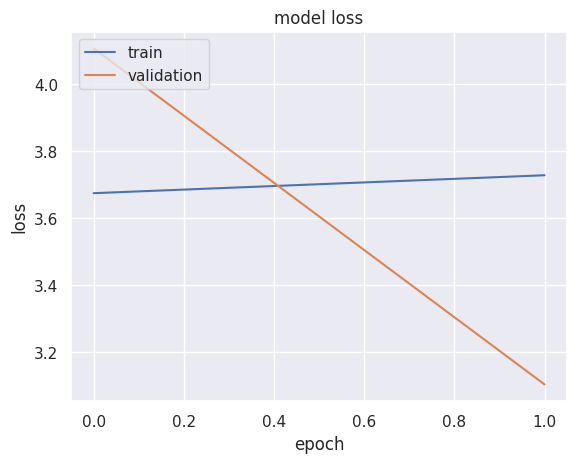

In [66]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history[0])
plt.plot(history[1])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<h4>Perplexity </h4>


In information theory, perplexity is a measurement of how well a probability distribution or probability model predicts a sample. It may be used to compare probability models. A low perplexity indicates the probability distribution is good at predicting the sample.

<br><br>
See the link for more details: 
https://towardsdatascience.com/perplexity-in-language-models-87a196019a94

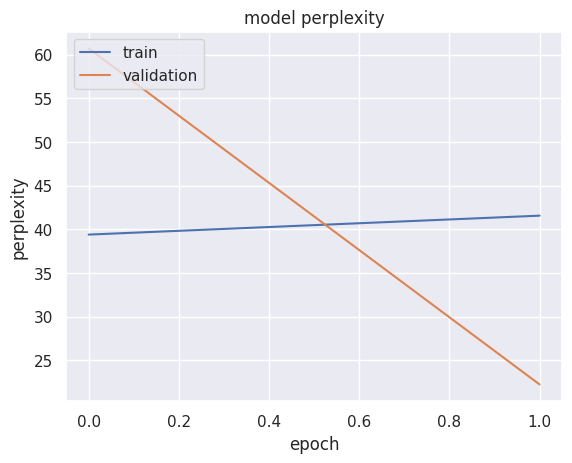

In [67]:
# summarize history for perplexity
plt.plot(history[2])
plt.plot(history[3])
plt.title('model perplexity')
plt.ylabel('perplexity')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

<h3> Attention Visualization </h3>

Visualizing the attention is the best part of working with transformers,it helps us in understanding what part of the input the model is paying more attention to, it improves interpretability of Neural Networks significantly and also helps in debugging should any problem occur.

In [68]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

Time taken to translate 0.1723637580871582 seconds
source = ['बच्चे', 'पार्क', 'में', 'खेल', 'रहे', 'हैं।']
----------------------------------------------------------------------------------------------------
target = ['children', 'play', 'in', 'the', 'park', '.']
----------------------------------------------------------------------------------------------------
translation = ['children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children']
-------------------------------

/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_127504/3470126203.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+translation)
/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_127504/3470126203.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+translation)
/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a

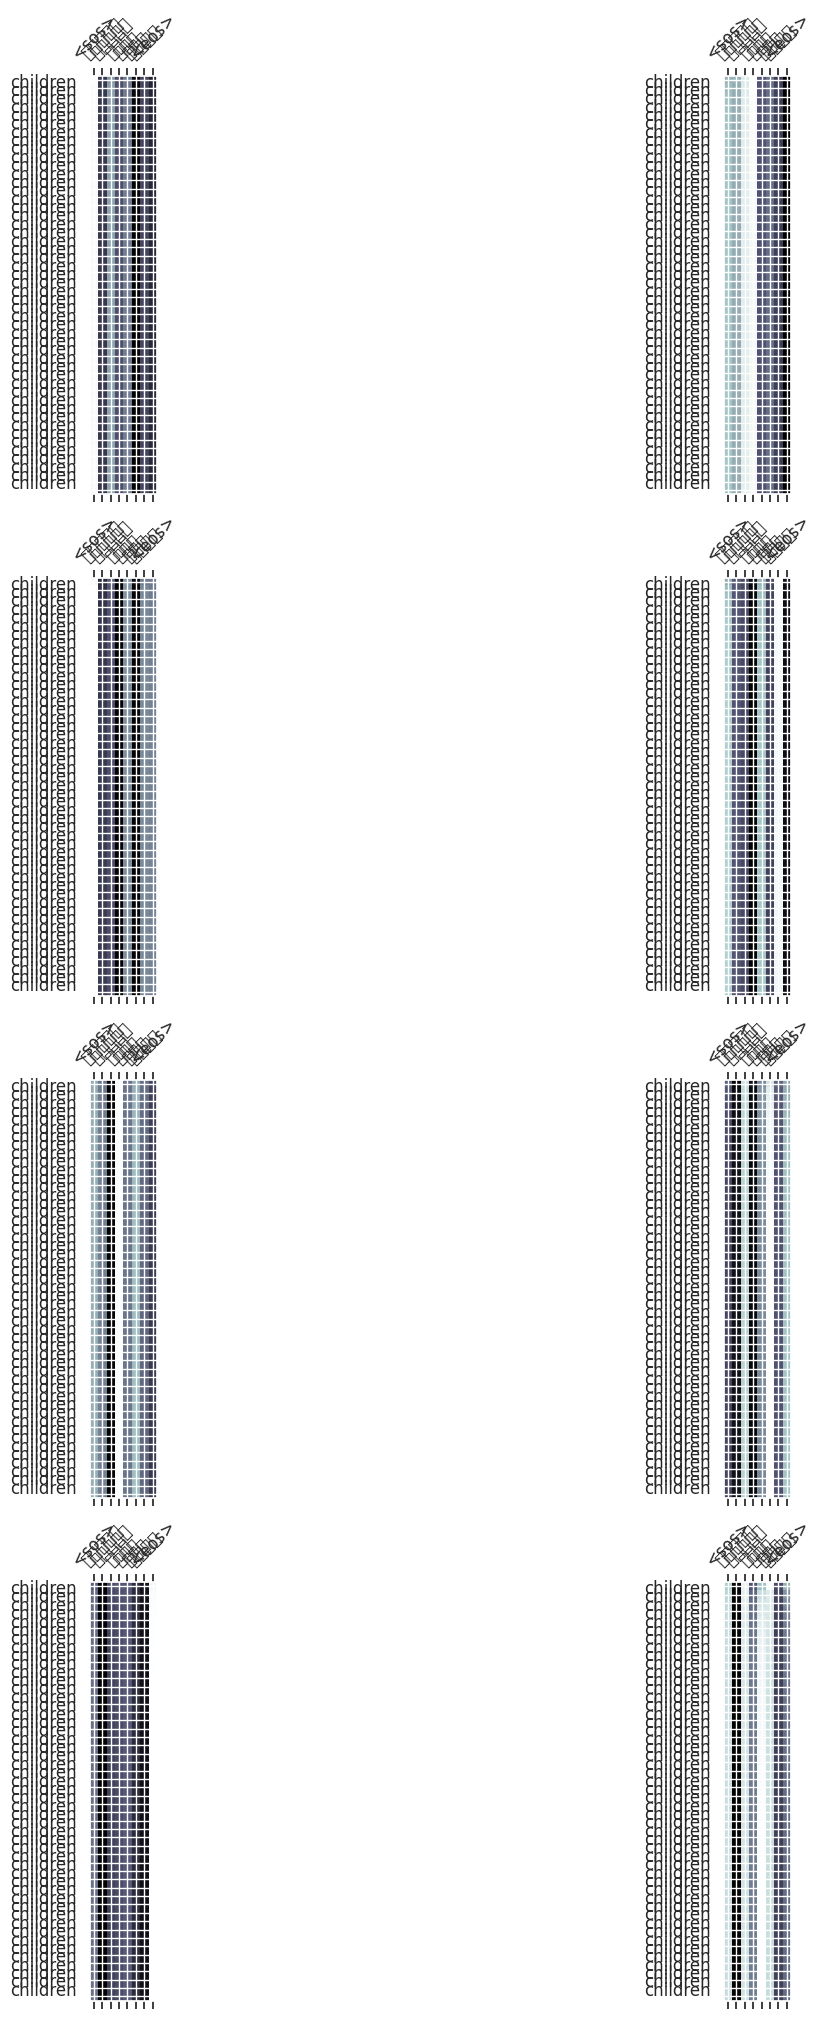

In [69]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']


translation, attention =  translate_sentence(src,
                                            source_process_pipeline,
                                            target_process_pipeline,
                                            spacy_hindi,
                                            transformer_model,device,
                                            max_length = 50,verbose = True)
print(f'source = {src}')
print('-'*100)
print(f'target = {trg}')
print('-'*100)
print(f'translation = {translation}')
print('-'*100)


display_attention(src, translation, attention,n_heads = NUM_DECODER_ATTN_HEADS)

Time taken to translate 0.18142461776733398 seconds
source = ['बच्चे', 'पार्क', 'में', 'खेल', 'रहे', 'हैं।']
----------------------------------------------------------------------------------------------------
target = ['children', 'play', 'in', 'the', 'park', '.']
----------------------------------------------------------------------------------------------------
translation = ['children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children']
------------------------------

/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_127504/3470126203.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+translation)
/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_127504/3470126203.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+translation)
/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a

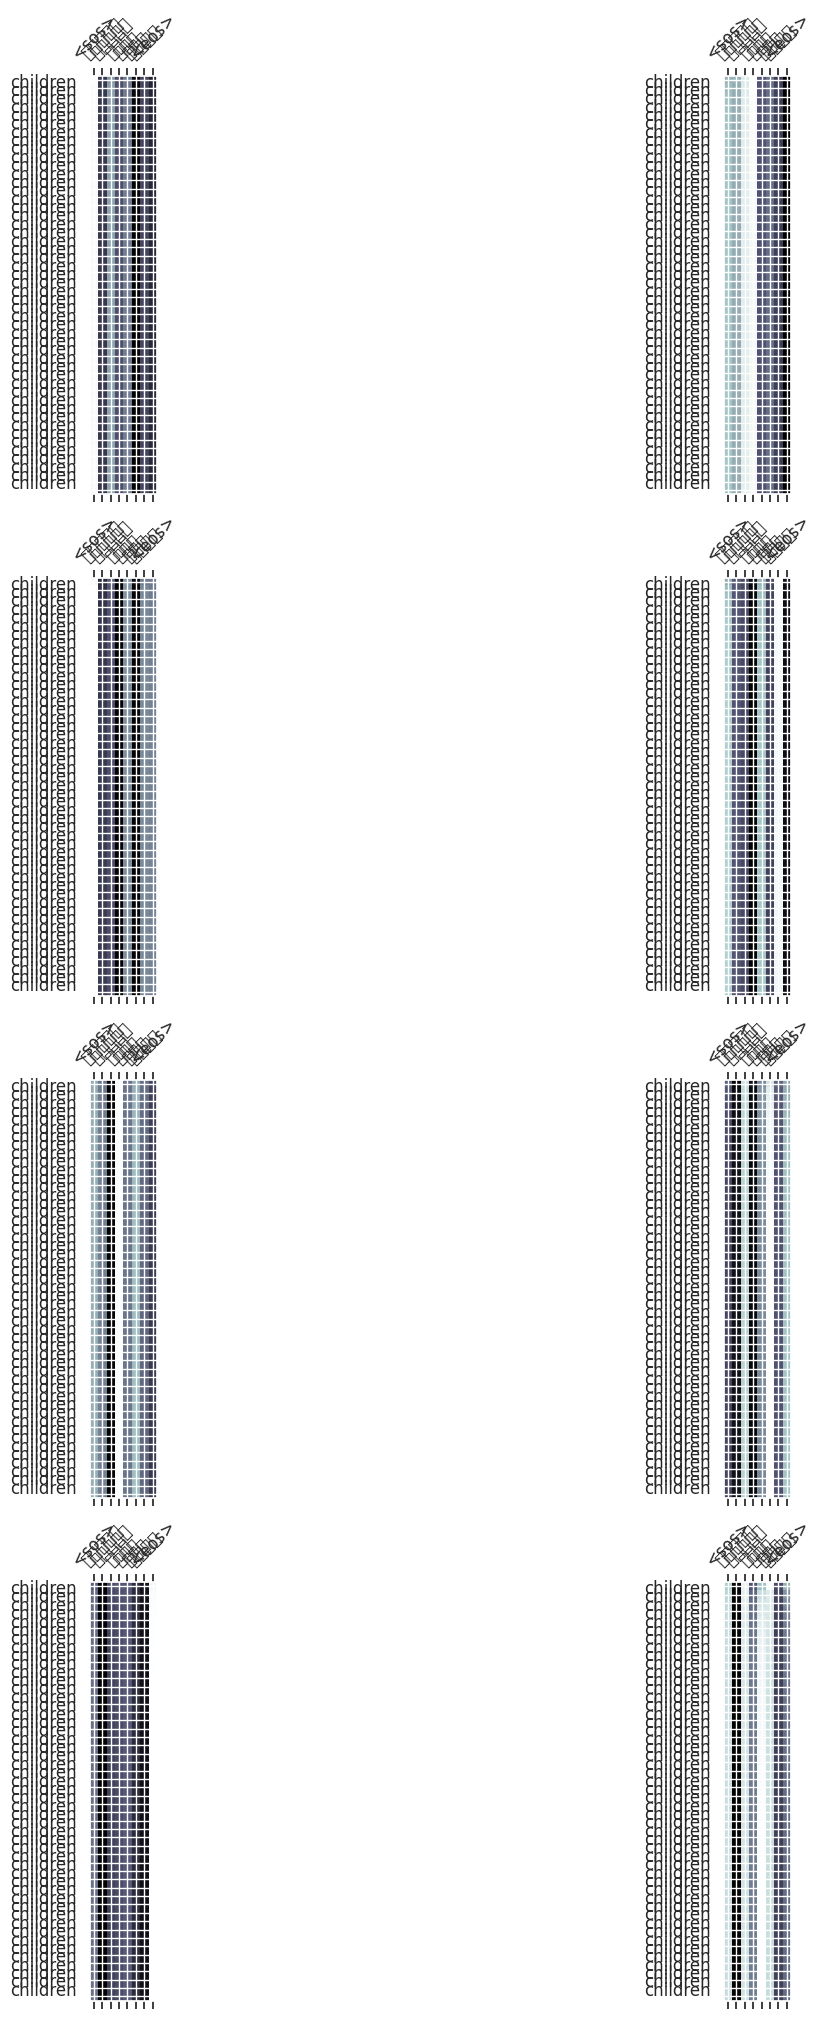

In [70]:
example_idx = 14

src = vars(validation_data.examples[example_idx])['src']
trg = vars(validation_data.examples[example_idx])['trg']


translation, attention =  translate_sentence(src,
                                            source_process_pipeline,
                                            target_process_pipeline,
                                            spacy_hindi,
                                            transformer_model,device,
                                            max_length = 50,verbose = True)
print(f'source = {src}')
print('-'*100)
print(f'target = {trg}')
print('-'*100)
print(f'translation = {translation}')
print('-'*100)


display_attention(src, translation, attention,n_heads = NUM_DECODER_ATTN_HEADS)

# Performance on Test Data

Time taken to translate 0.16905498504638672 seconds
source = ['बच्चे', 'पार्क', 'में', 'खेल', 'रहे', 'हैं।']
----------------------------------------------------------------------------------------------------
target = ['children', 'play', 'in', 'the', 'park', '.']
----------------------------------------------------------------------------------------------------
translation = ['children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children', 'children']
------------------------------

/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_127504/3470126203.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+translation)
/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_127504/3470126203.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+translation)
/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a

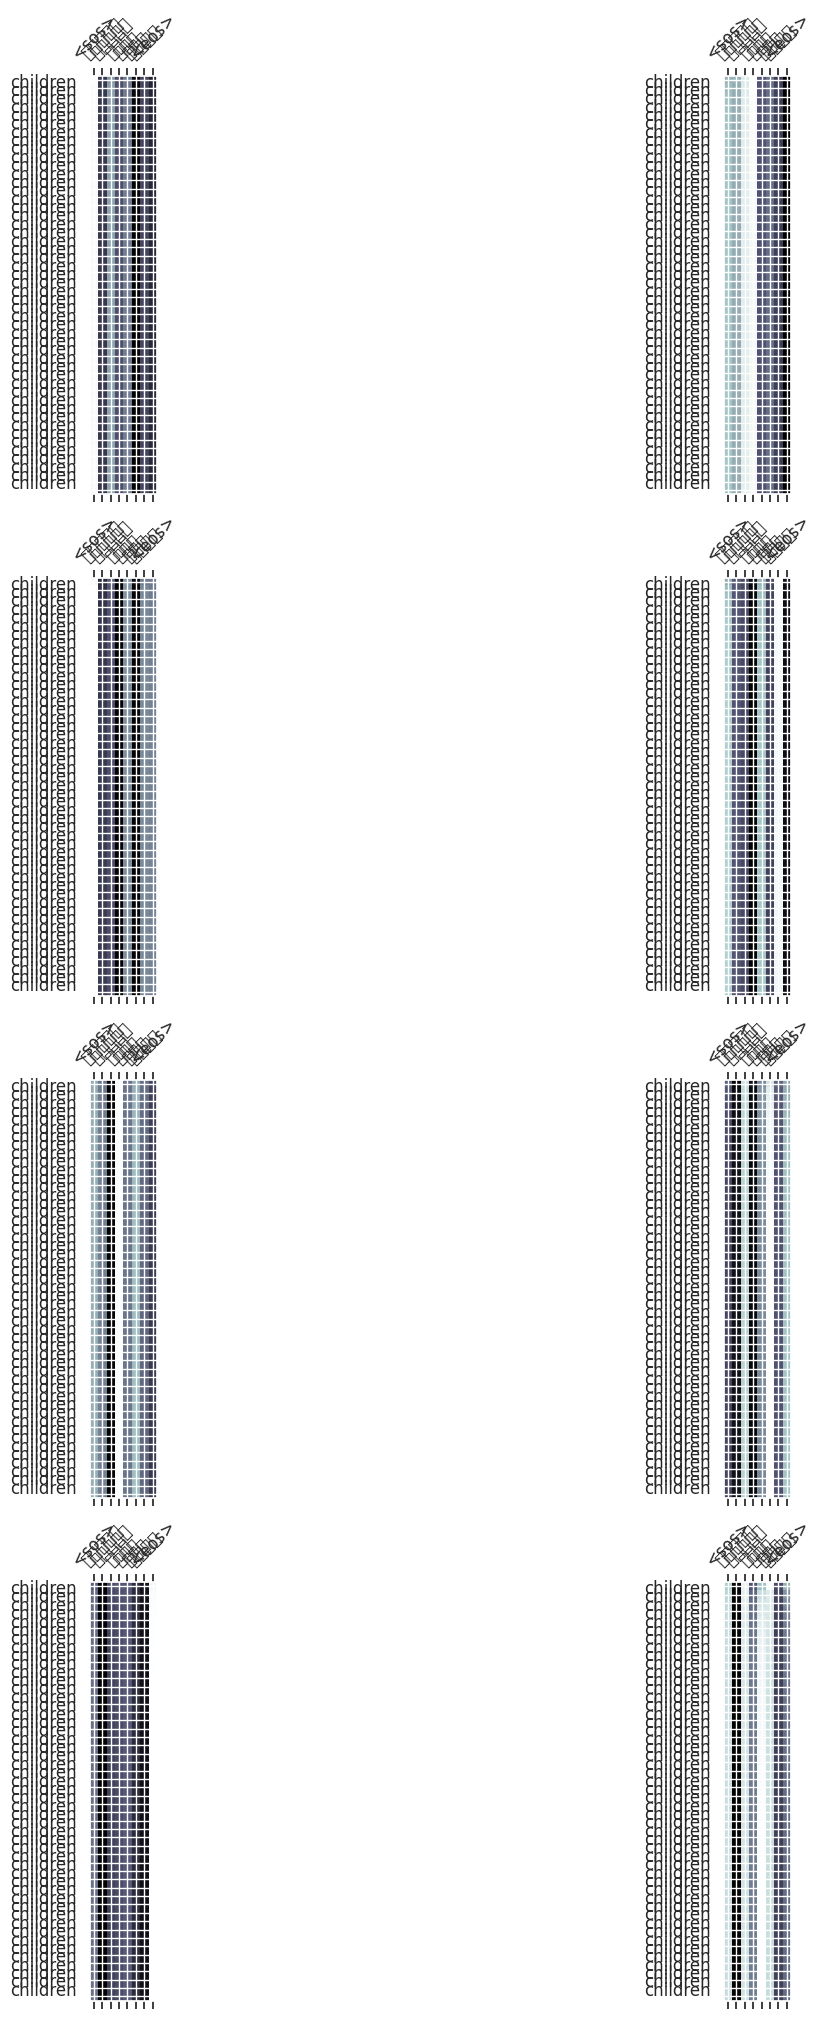

In [71]:
example_idx = 8

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']


translation, attention =  translate_sentence(src,
                                            source_process_pipeline,
                                            target_process_pipeline,
                                            spacy_hindi,
                                            transformer_model,device,
                                            max_length = 50,verbose = True)
print(f'source = {src}')
print('-'*100)
print(f'target = {trg}')
print('-'*100)
print(f'translation = {translation}')
print('-'*100)

display_attention(src, translation, attention,n_heads = NUM_DECODER_ATTN_HEADS)

Time taken to translate 0.17712140083312988 seconds
source = ['एक', 'आदमी', 'बेंच', 'पर', 'बैठा', 'है।']
----------------------------------------------------------------------------------------------------
target = ['a', 'man', 'sits', 'on', 'a', 'bench', '.']
----------------------------------------------------------------------------------------------------
translation = ['on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on', 'on']
----------------------------------------------------------------------------------------------------


/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_127504/3470126203.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+translation)
/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_127504/3470126203.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+translation)
/tmp/ipykernel_127504/3470126203.py:16: UserWarning: set_ticklabels() should only be used with a

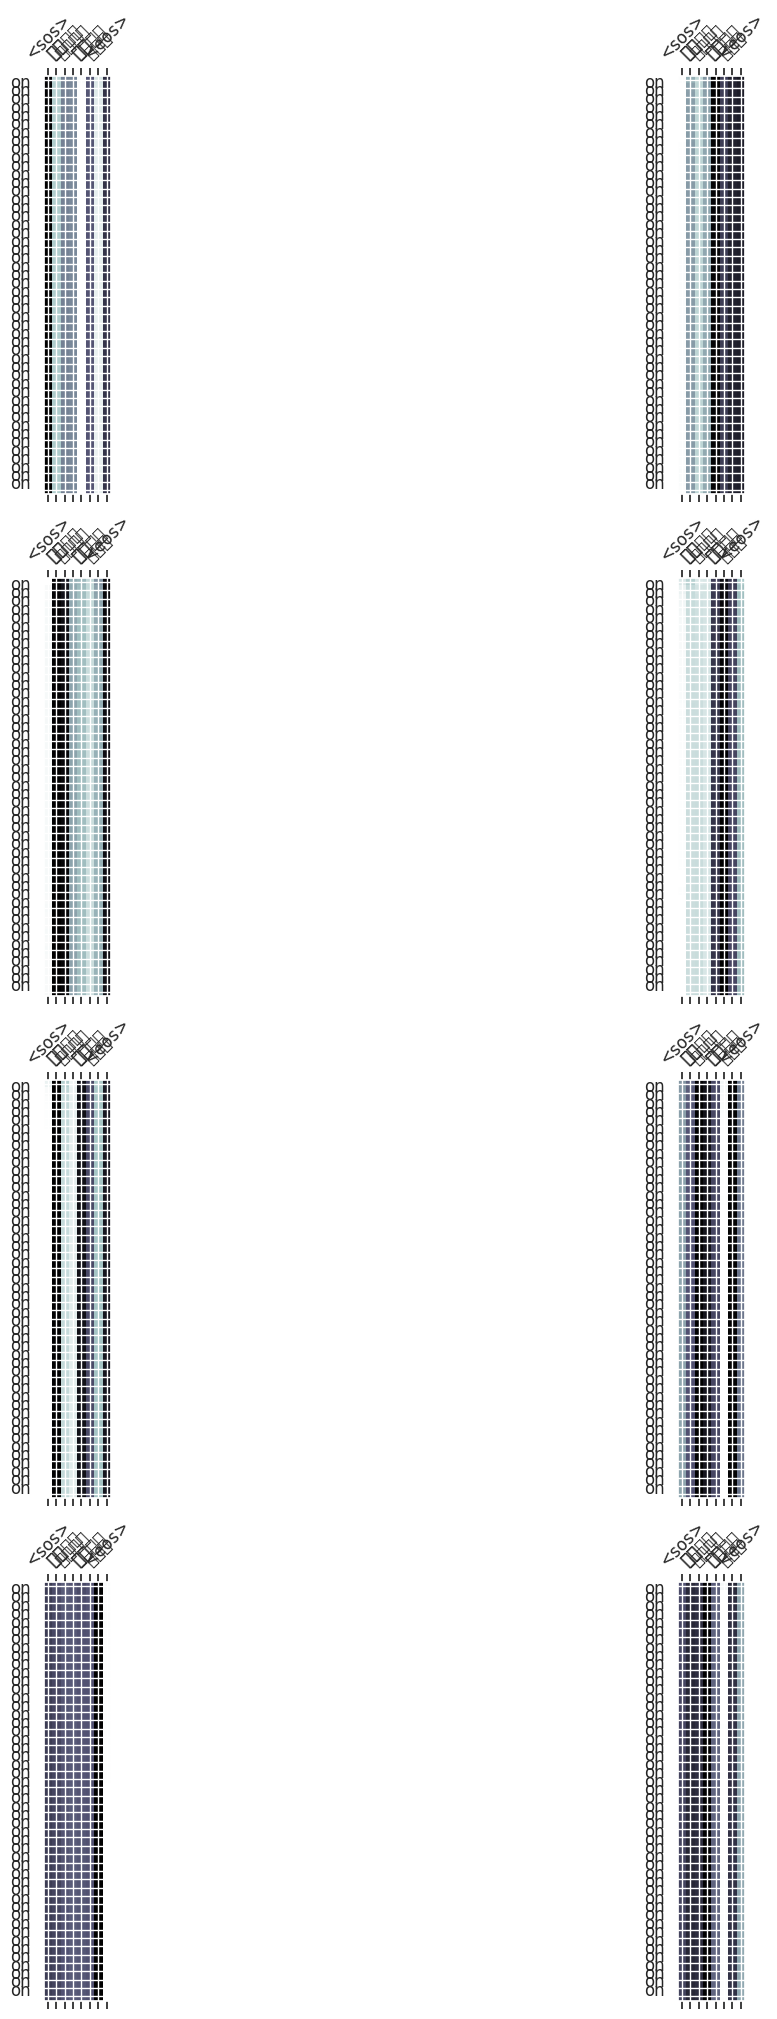

In [72]:
example_idx = 21

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']


translation, attention =  translate_sentence(src,
                                            source_process_pipeline,
                                            target_process_pipeline,
                                            spacy_hindi,
                                            transformer_model,device,
                                            max_length = 50,verbose = True)
print(f'source = {src}')
print('-'*100)
print(f'target = {trg}')
print('-'*100)
print(f'translation = {translation}')
print('-'*100)


display_attention(src, translation, attention,n_heads = NUM_DECODER_ATTN_HEADS)

<h3> BLEU Score </h3>

Paper : https://www.aclweb.org/anthology/P02-1040.pdf <br>
Library : https://pytorch.org/text/stable/data_metrics.html <br>

The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence. A perfect match results in a score of 100.0, whereas a perfect mismatch results in a score of 0.0.<br><br>
Lets create a function which calculates the BLEU score for every epoch.

In [73]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data,source_field, target_field,source_tokenizer,
                       transformer_model,device, max_len = 50):
    
    transformer_model.eval()
    target_tokens = []
    predicted_tokens = []
    
    start = time()
    with torch.no_grad():
        
        for item in tqdm(data):
            
            source = vars(item)['src']
            target = vars(item)['trg']
                
            
            predicted_sentence,attention = translate_sentence(source,
                                                   source_field,target_field,
                                                   source_tokenizer,
                                                   transformer_model,device,
                                                   max_length = 50,verbose = False)
                
            predicted_tokens.append(predicted_sentence)
            target_tokens.append([target])
            

    return bleu_score(predicted_tokens, target_tokens)

In [74]:
bleu_score = calculate_bleu(test_data,source_process_pipeline,
                            target_process_pipeline,spacy_hindi,transformer_model,device, max_len = 50)


print(f'BLEU score on Test Data = {bleu_score*100}')

  0%|          | 0/45 [00:00<?, ?it/s]

BLEU score on Test Data = 0.0


We acheived a perplexity of ~35 , which quite good, if we had trained the model on a significantly larger corpus, the results would have been even better.

<h3> Conclusion </h3>

So, now we are done with the neccesary implementations, one can try out different ways of implementations some of which were skipped here like a scheduled learning rate with warmup and cooldown, and static positional encodings using a cosine function like discussed in the paper. Feel free to reach out and add any suggestions !!  

<h2> References and Additional Readings </h2>

[1] Attention is All You Need, Paper https://arxiv.org/pdf/1706.03762.pdf

[2] The Illustrated Transformer by Jay Alamar, https://jalammar.github.io/illustrated-transformer/

[3] What Does BERT Look At? An Analysis of BERT’s Attention,
https://arxiv.org/pdf/1906.04341.pdf

[4] Bertology, https://huggingface.co/transformers/bertology.html

[5] The Annotated Transformer (PyTorch Implementation (some portions of the code might be obsolete now), http://nlp.seas.harvard.edu/2018/04/03/attention.html

[6] BenTrevett and jadore, https://github.com/jadore801120/attention-is-all-you-need-pytorch

[7] Advanced NLP, https://people.cs.umass.edu/~miyyer/cs685/